In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sps as sps
import lbg_forecast.sfh as sfh
import lbg_forecast.priors as pr
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.zhistory as zh
import lbg_forecast.priors as pr
import lbg_forecast.noise as noise
import lbg_forecast.selection as sel
import lbg_forecast.nz_sim as nz

import getdist
from getdist import plots, MCSamples

In [3]:
hyperparameter_mu_bounds, hyperparameter_sigma_max = hyp.uniform_hyperparameter_bounds()

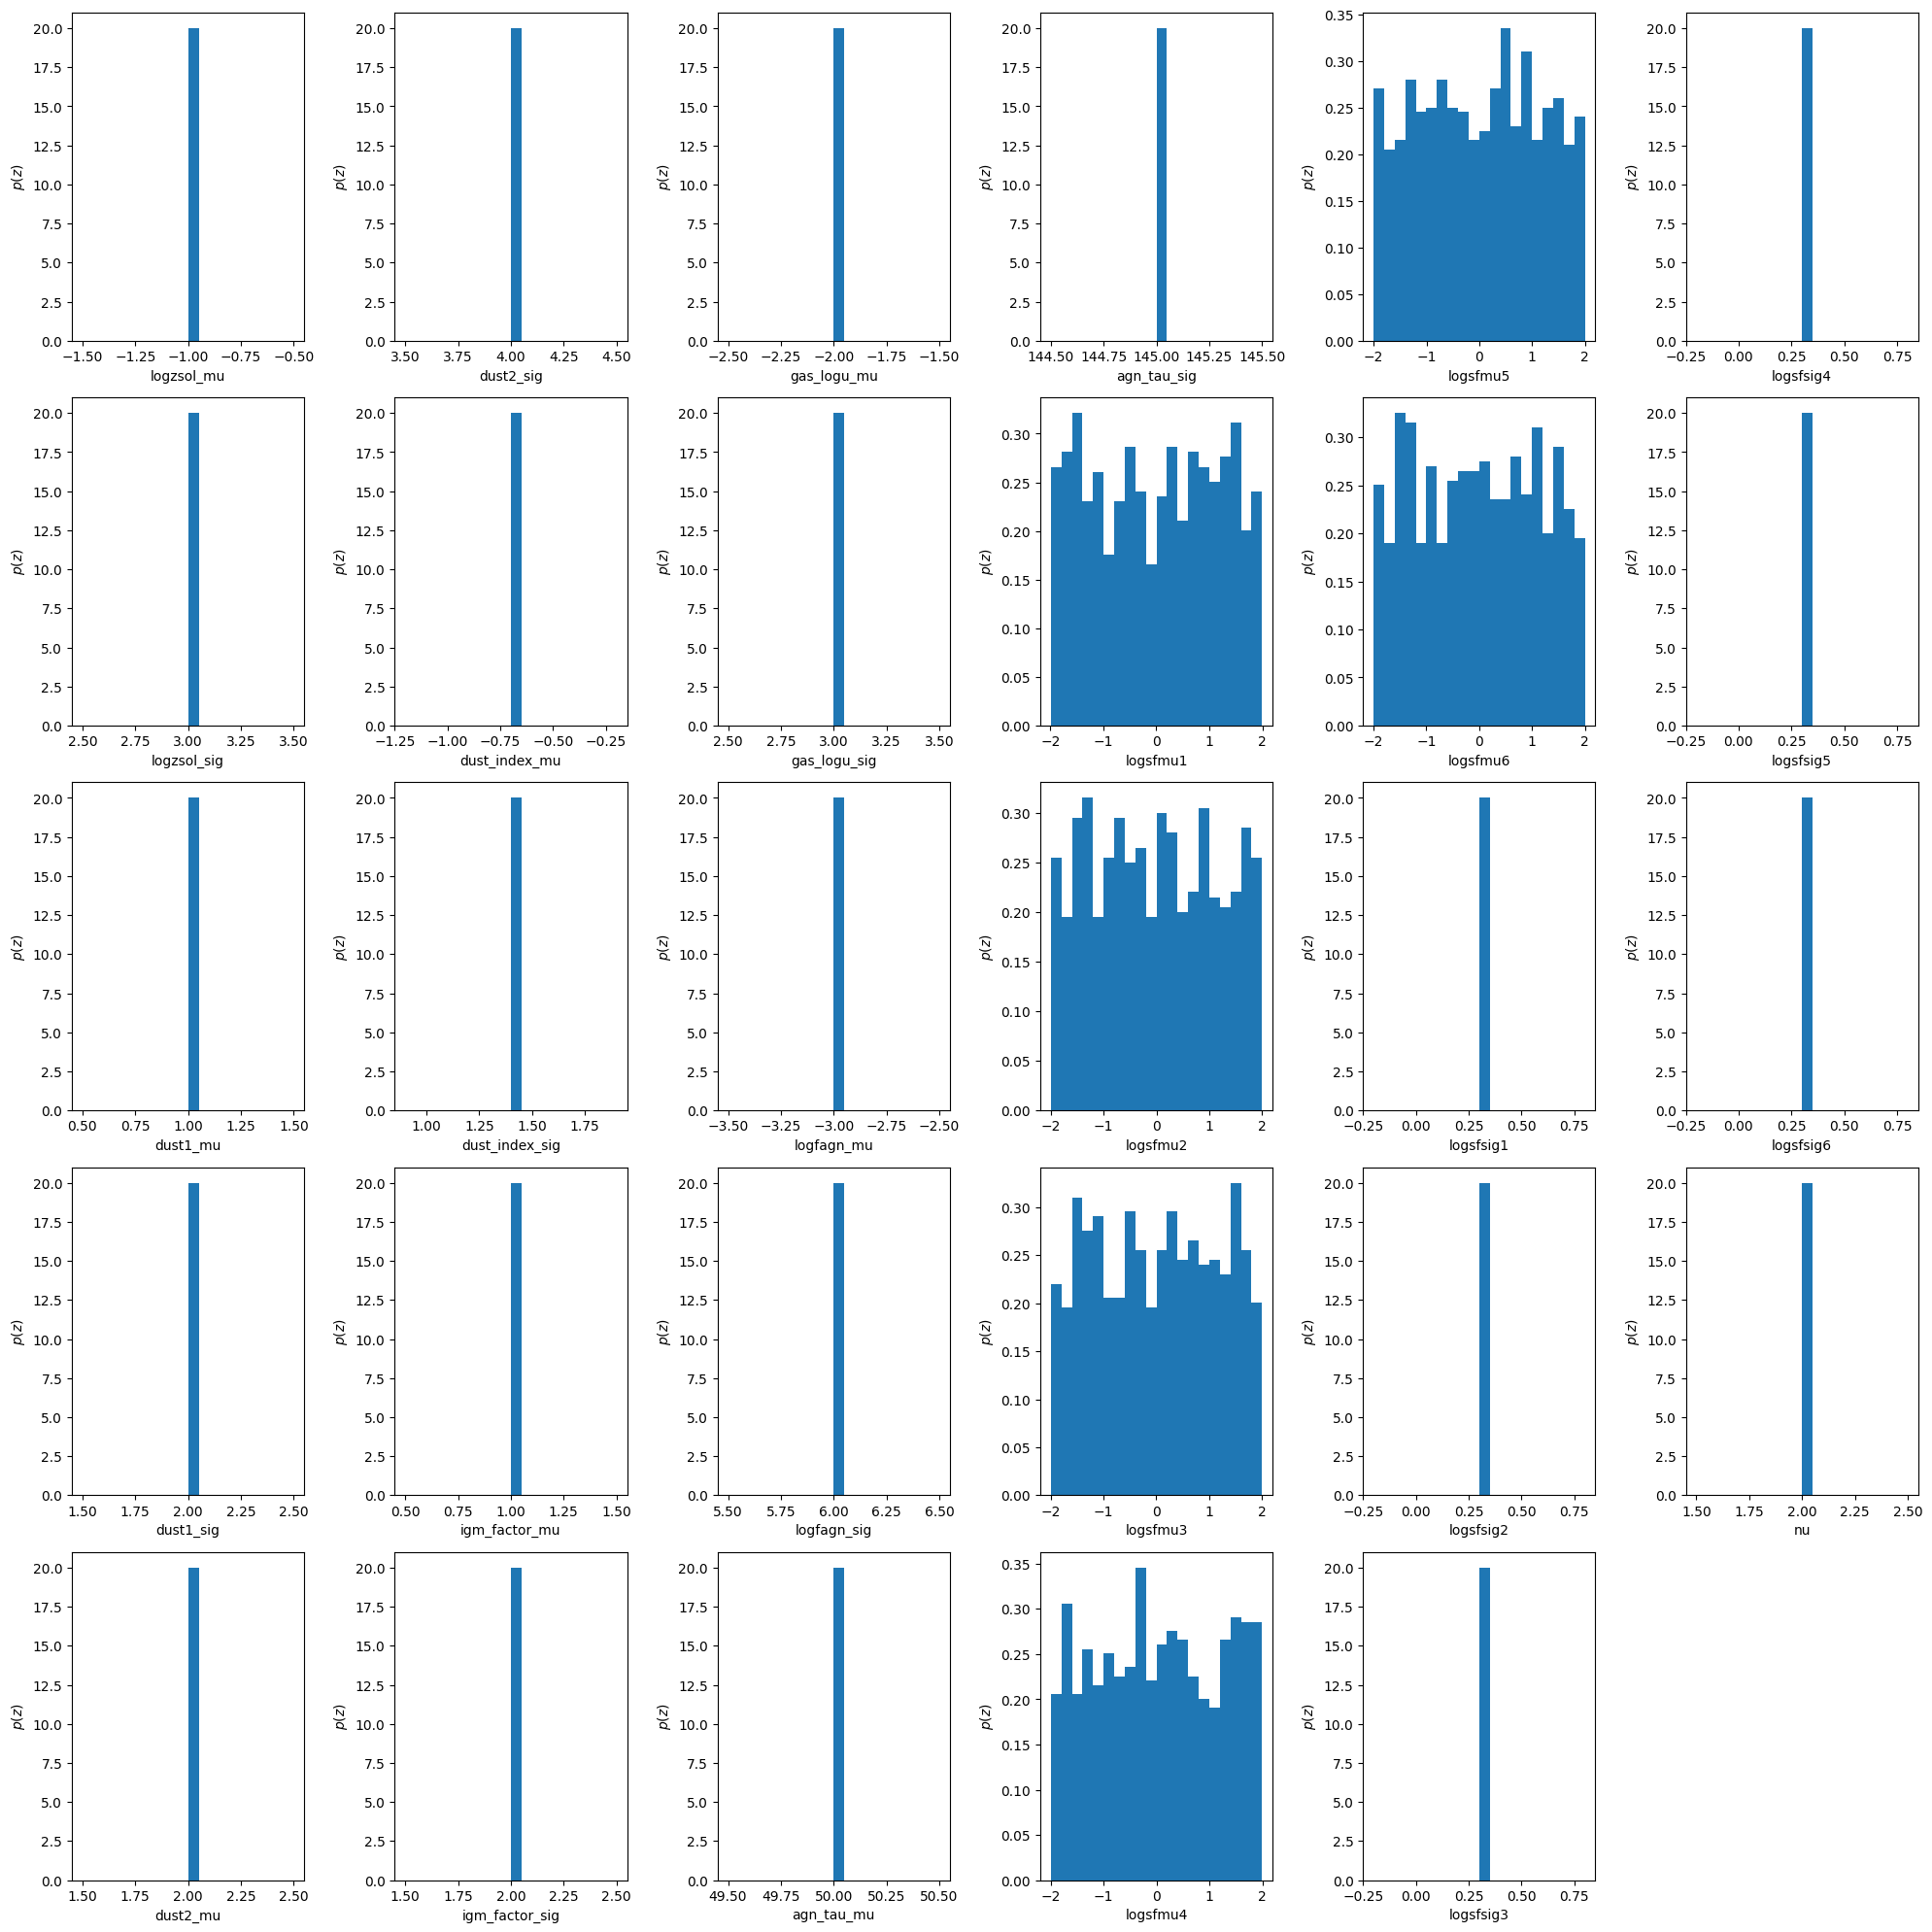

In [4]:
prior_parameters = hyp.sample_prior_parameters(1000, hyperparameter_mu_bounds, hyperparameter_sigma_max)
hyp.plot_hyperparameters(prior_parameters)

In [5]:
redshift_mass_prior_parameters = pr.setup_redshift_and_mass_priors(z_max=15)

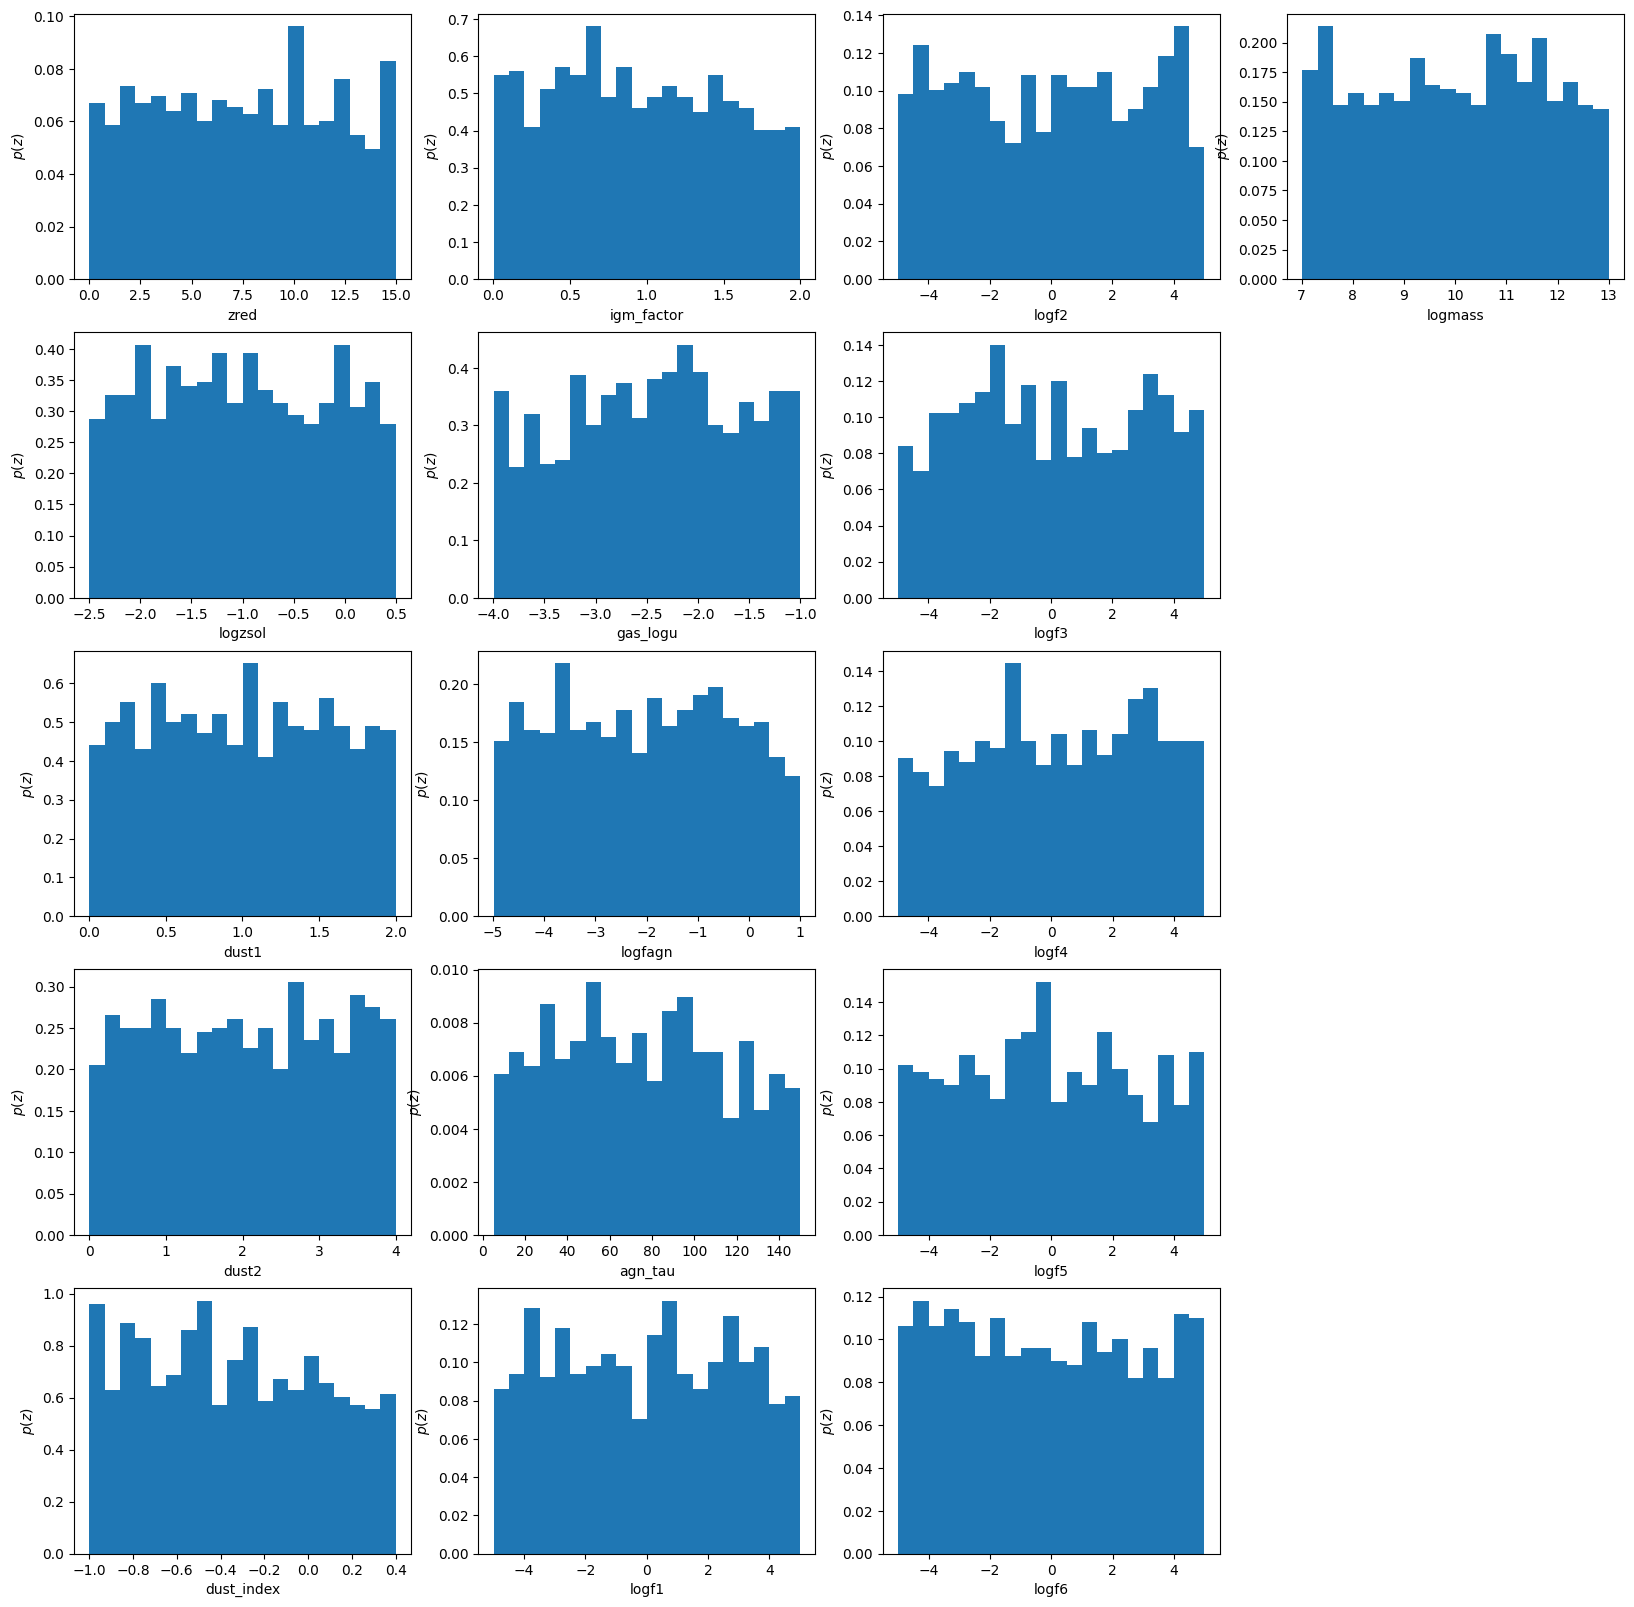

In [6]:
sps_parameters = pop.generate_sps_parameters(1000, prior_parameters[np.random.randint(0, 1000),:], redshift_mass_prior_parameters, uniform_redshift_mass=True, uniform_logf=True)
pop.plot_galaxy_population(sps_parameters, rows=5, nbins=20)

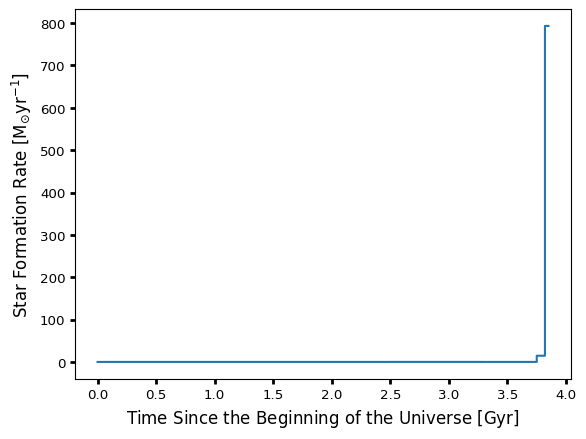

In [7]:
sfh.sps_parameters_to_sfh(sps_parameters[0,:], sfh.default_agebins())

0.000813508158308752 0.0008135081583062954 24883881827.439297 24883881827.4393


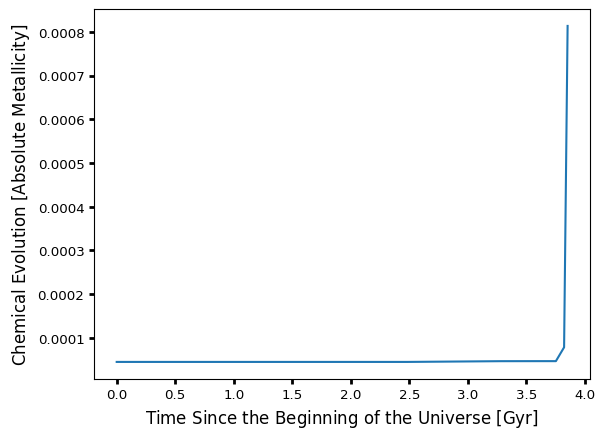

In [8]:
zh.sps_parameters_to_zhistory(sps_parameters[0,:], sfh.default_agebins())

In [ ]:
photometry = sps.simulate_photometry(sps_parameters, "lsst", imf=1, dust=0, nebem=False, zhistory=False, enable_mpi=False)

In [16]:
lbg_dropouts, params = noise.get_noisy_magnitudes(sps_parameters, photometry, random_state=42, return_params=True)
lbg_photometry = sel.colours(lbg_dropouts)
uparams, gparams, rparams = nz.apply_cuts(lbg_photometry, return_all_params=True)
uparams.shape

(149, 16)